In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import NearestNeighbors
from sklearn.random_projection import SparseRandomProjection
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:

from google.colab import drive
import tarfile
import shutil

drive.mount('/content/drive')


archive_path = "/content/drive/MyDrive/metal_nut.tar.xz"
extracted_path = "/content/metal_nut"

print(f"Archive path: {archive_path}")
print(f"Archive exists: {os.path.exists(archive_path)}")


if os.path.exists(archive_path) and not os.path.exists(extracted_path):
    print("Extracting dataset...")


    with tarfile.open(archive_path, 'r:xz') as tar:
        tar.extractall('/content/')

    print("Dataset extracted successfully!")
elif os.path.exists(extracted_path):
    print("Dataset already extracted.")
else:
    print("ERROR: Dataset archive not found!")


if os.path.exists(extracted_path):
    print(f"\nExtracted dataset path: {extracted_path}")
    print("Dataset klasörleri:")
    for item in os.listdir(extracted_path):
        print(f"  - {item}")


    train_path = os.path.join(extracted_path, 'train')
    test_path = os.path.join(extracted_path, 'test')

    if os.path.exists(train_path):
        print(f"\nTrain klasörleri:")
        for item in os.listdir(train_path):
            count = len(os.listdir(os.path.join(train_path, item))) if os.path.isdir(os.path.join(train_path, item)) else 0
            print(f"  - {item}: {count} images")

    if os.path.exists(test_path):
        print(f"\nTest klasörleri:")
        for item in os.listdir(test_path):
            count = len(os.listdir(os.path.join(test_path, item))) if os.path.isdir(os.path.join(test_path, item)) else 0
            print(f"  - {item}: {count} images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive path: /content/drive/MyDrive/metal_nut.tar.xz
Archive exists: True
Dataset already extracted.

Extracted dataset path: /content/metal_nut
Dataset klasörleri:
  - readme.txt
  - license.txt
  - test
  - train
  - ground_truth

Train klasörleri:
  - good: 220 images

Test klasörleri:
  - bent: 25 images
  - color: 22 images
  - good: 22 images
  - flip: 23 images
  - scratch: 23 images


In [ ]:

class MetalNutDataset(Dataset):

    def __init__(self, root_path, split='train', transform=None, is_train=True):
        self.root_path = root_path
        self.split = split
        self.transform = transform
        self.is_train = is_train


        self.data_path = os.path.join(root_path, split)
        self.gt_path = os.path.join(root_path, 'ground_truth') if not is_train else None

        self.image_paths = []
        self.labels = []
        self.mask_paths = []

        self._load_dataset()

    def _load_dataset(self):

        if self.is_train:

            good_path = os.path.join(self.data_path, 'good')
            if os.path.exists(good_path):
                for img_name in os.listdir(good_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(good_path, img_name))
                        self.labels.append(0)
                        self.mask_paths.append(None)
        else:

            for class_name in os.listdir(self.data_path):
                class_path = os.path.join(self.data_path, class_name)
                if os.path.isdir(class_path):
                    label = 0 if class_name == 'good' else 1

                    for img_name in os.listdir(class_path):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(class_path, img_name)
                            self.image_paths.append(img_path)
                            self.labels.append(label)


                            if label == 1 and self.gt_path:
                                mask_path = os.path.join(self.gt_path, class_name, img_name)
                                self.mask_paths.append(mask_path if os.path.exists(mask_path) else None)
                            else:
                                self.mask_paths.append(None)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        image = self._enhance_contrast(image)


        mask = None
        if self.mask_paths[idx] is not None:
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                mask = mask / 255.0


        if self.transform:
            image = self.transform(image)


        if mask is None:
            mask = np.zeros((self.input_size if hasattr(self, 'input_size') else 256,
                           self.input_size if hasattr(self, 'input_size') else 256), dtype=np.float32)

        return {
            'image': image,
            'label': self.labels[idx],
            'mask': mask,
            'path': img_path
        }

    def _enhance_contrast(self, image):

        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)


        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)


        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

        return enhanced

class PatchCoreModel(nn.Module):

    def __init__(self, backbone='resnet50', layers=['layer2', 'layer3'],
                 input_size=256, coreset_sampling_ratio=0.1):
        super().__init__()

        self.backbone_name = backbone
        self.layers = layers
        self.input_size = input_size
        self.coreset_sampling_ratio = coreset_sampling_ratio


        self.backbone = self._load_backbone()
        self.feature_extractor = self._create_feature_extractor()


        self.memory_bank = None
        self.coreset_idx = None
        self.nn_model = None

    def _load_backbone(self):

        if self.backbone_name == 'resnet50':
            backbone = models.resnet50(pretrained=True)
        elif self.backbone_name == 'wide_resnet50_2':
            backbone = models.wide_resnet50_2(pretrained=True)
        else:
            raise ValueError(f"Unsupported backbone: {self.backbone_name}")


        backbone.eval()

        return backbone

    def _create_feature_extractor(self):

        feature_extractor = {}

        def hook_fn(name):
            def hook(module, input, output):
                feature_extractor[name] = output
            return hook


        hooks_registered = []


        for name, module in self.backbone.named_modules():
            if name in self.layers:
                module.register_forward_hook(hook_fn(name))
                hooks_registered.append(name)
                print(f"Hook registered for: {name}")

        print(f"Total hooks registered: {len(hooks_registered)}")
        if len(hooks_registered) == 0:
            print("WARNING: No hooks registered! Available modules:")
            for name, module in self.backbone.named_modules():
                if 'layer' in name.lower() and len(name) < 20:  # Avoid too long names
                    print(f"  - {name}: {type(module)}")

        return feature_extractor

    def extract_features(self, x):

        self.feature_extractor.clear()

        with torch.no_grad():

            x = self.backbone.conv1(x)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)

            x = self.backbone.layer1(x)
            x = self.backbone.layer2(x)
            x = self.backbone.layer3(x)
            x = self.backbone.layer4(x)


        if len(self.feature_extractor) == 0:
            print("Available layers:")
            for name, module in self.backbone.named_modules():
                if 'layer' in name and len(name) < 10:
                    print(f"  - {name}")


        features = []
        for layer in self.layers:
            if layer in self.feature_extractor:
                feat = self.feature_extractor[layer]
                # Adaptive pooling to same size
                feat = F.adaptive_avg_pool2d(feat, (28, 28))
                features.append(feat)
                print(f"✅ Extracted features from {layer}: {feat.shape}")
            else:
                print(f"❌ Layer {layer} not found in feature extractor!")
                print(f"Available: {list(self.feature_extractor.keys())}")


        if len(features) == 0:
            raise ValueError(f"No features extracted! Available layers: {list(self.feature_extractor.keys())}")


        if len(features) > 1:
            features = torch.cat(features, dim=1)
            print(f"✅ Concatenated features shape: {features.shape}")
        else:
            features = features[0]
            print(f"✅ Single feature shape: {features.shape}")

        return features

    def build_memory_bank(self, dataloader):

        print("Building memory bank...")

        all_features = []

        for batch in tqdm(dataloader, desc="Extracting features"):
            images = batch['image'].to(device)
            features = self.extract_features(images)


            b, c, h, w = features.shape
            features = features.reshape(b, c, h*w).permute(0, 2, 1)  # [B, HW, C]
            features = features.reshape(-1, c)  # [B*HW, C]

            all_features.append(features.cpu().numpy())


        all_features = np.concatenate(all_features, axis=0)
        print(f"Total features: {all_features.shape}")


        self.memory_bank, self.coreset_idx = self._coreset_subsampling(all_features)
        print(f"Coreset size: {self.memory_bank.shape}")


        self.nn_model = NearestNeighbors(n_neighbors=1, metric='cosine')
        self.nn_model.fit(self.memory_bank)

    def _coreset_subsampling(self, features):
        """Fast coreset subsampling for memory efficiency"""
        n_samples = int(len(features) * self.coreset_sampling_ratio)

        print(f"Coreset sampling: {len(features)} -> {n_samples} samples")


        if n_samples >= 10000:
            print("Using random sampling (fastest)")
            selected_idx = np.random.choice(len(features), n_samples, replace=False)
            return features[selected_idx], selected_idx


        try:
            from sklearn.cluster import MiniBatchKMeans
            print("Using K-means based sampling")


            if features.shape[1] > 512:
                from sklearn.decomposition import PCA
                pca = PCA(n_components=512, random_state=42)
                features_reduced = pca.fit_transform(features)
            else:
                features_reduced = features


            kmeans = MiniBatchKMeans(n_clusters=n_samples, random_state=42, batch_size=1000)
            kmeans.fit(features_reduced)


            selected_idx = []
            for center in tqdm(kmeans.cluster_centers_, desc="Finding closest points"):
                distances = np.linalg.norm(features_reduced - center, axis=1)
                closest_idx = np.argmin(distances)
                selected_idx.append(closest_idx)

            selected_idx = np.array(selected_idx)
            return features[selected_idx], selected_idx

        except ImportError:
            print("Sklearn not available, using random sampling")
            selected_idx = np.random.choice(len(features), n_samples, replace=False)
            return features[selected_idx], selected_idx

    def predict(self, dataloader):

        print("Predicting anomalies...")

        all_scores = []
        all_labels = []
        all_masks = []
        anomaly_maps = []

        for batch in tqdm(dataloader, desc="Predicting"):
            images = batch['image'].to(device)
            labels = batch['label'].numpy()
            masks = batch['mask']


            features = self.extract_features(images)
            b, c, h, w = features.shape


            features = features.reshape(b, c, h*w).permute(0, 2, 1)  # [B, HW, C]

            batch_scores = []
            batch_maps = []

            for i in range(b):

                patch_features = features[i].cpu().numpy()  # [HW, C]
                distances, _ = self.nn_model.kneighbors(patch_features)
                distances = distances.flatten()


                anomaly_map = distances.reshape(h, w)


                anomaly_map = cv2.resize(anomaly_map, (self.input_size, self.input_size))


                image_score = np.max(distances)

                batch_scores.append(image_score)
                batch_maps.append(anomaly_map)

            all_scores.extend(batch_scores)
            all_labels.extend(labels)
            anomaly_maps.extend(batch_maps)


            for mask in masks:
                if mask is not None:

                    if hasattr(mask, 'numpy'):
                        mask = mask.numpy()

                    if len(mask.shape) > 2:
                        mask = mask.squeeze()
                    mask = mask.astype(np.float32)
                    mask = cv2.resize(mask, (self.input_size, self.input_size))
                all_masks.append(mask)

        return np.array(all_scores), np.array(all_labels), all_masks, anomaly_maps




✅ Class definitions loaded successfully!


In [ ]:

def calculate_metrics(scores, labels, masks, anomaly_maps):
    """Evaluation metrics hesapla"""

    image_auroc = roc_auc_score(labels, scores)


    pixel_scores = []
    pixel_labels = []

    for i, (label, mask, amap) in enumerate(zip(labels, masks, anomaly_maps)):
        if label == 1 and mask is not None:
            pixel_scores.extend(amap.flatten())
            pixel_labels.extend(mask.flatten())

    pixel_auroc = None
    if len(pixel_scores) > 0:
        pixel_auroc = roc_auc_score(pixel_labels, pixel_scores)

    return {
        'image_auroc': image_auroc,
        'pixel_auroc': pixel_auroc,
        'num_normal': np.sum(labels == 0),
        'num_anomaly': np.sum(labels == 1)
    }

def visualize_results(images, labels, scores, anomaly_maps, save_path=None, num_samples=8):
    """Sonuçları görselleştir"""
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))


    normal_idx = np.where(labels == 0)[0]
    anomaly_idx = np.where(labels == 1)[0]

    selected_idx = []
    selected_idx.extend(normal_idx[:num_samples//2])
    selected_idx.extend(anomaly_idx[:num_samples//2])
    selected_idx = selected_idx[:num_samples]

    for i, idx in enumerate(selected_idx):
        if i >= num_samples:
            break


        if hasattr(images[idx], 'numpy'):
            img = images[idx].numpy().transpose(1, 2, 0)
        else:
            img = images[idx]

        axes[0, i].imshow(img)
        axes[0, i].set_title(f'{"Normal" if labels[idx] == 0 else "Anomaly"}\nScore: {scores[idx]:.3f}')
        axes[0, i].axis('off')


        axes[1, i].imshow(anomaly_maps[idx], cmap='jet')
        axes[1, i].set_title('Anomaly Map')
        axes[1, i].axis('off')


        overlay = img.copy()
        heatmap = plt.cm.jet(anomaly_maps[idx] / np.max(anomaly_maps[idx]))[:,:,:3]
        overlay = 0.7 * overlay + 0.3 * heatmap
        axes[2, i].imshow(overlay)
        axes[2, i].set_title('Overlay')
        axes[2, i].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()



✅ Evaluation functions loaded successfully!


In [ ]:


CONFIG = {
    'dataset_path': '/content/metal_nut',
    'backbone': 'resnet50',
    'layers': ['layer2', 'layer3'],
    'input_size': 256,
    'batch_size': 32,
    'coreset_ratio': 0.01,
    'save_model': True,
    'model_save_path': '/content/drive/MyDrive/patchcore_metal_nut.pkl'
}


print(f"Configuration: {CONFIG}")


PatchCore Metal Nut Anomaly Detection
Configuration: {'dataset_path': '/content/metal_nut', 'backbone': 'resnet50', 'layers': ['layer2', 'layer3'], 'input_size': 256, 'batch_size': 32, 'coreset_ratio': 0.01, 'save_model': True, 'model_save_path': '/content/drive/MyDrive/patchcore_metal_nut.pkl'}
✅ Configuration loaded successfully!


In [ ]:

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((CONFIG['input_size'], CONFIG['input_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])


train_dataset = MetalNutDataset(
    CONFIG['dataset_path'],
    split='train',
    transform=transform,
    is_train=True
)

test_dataset = MetalNutDataset(
    CONFIG['dataset_path'],
    split='test',
    transform=transform,
    is_train=False
)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)



Train samples: 220
Test samples: 115
✅ Data preparation completed!


In [ ]:

model = PatchCoreModel(
    backbone=CONFIG['backbone'],
    layers=CONFIG['layers'],
    input_size=CONFIG['input_size'],
    coreset_sampling_ratio=CONFIG['coreset_ratio']
).to(device)


print(f"Backbone: {CONFIG['backbone']}")
print(f"Layers: {CONFIG['layers']}")
print(f"Input size: {CONFIG['input_size']}")
print(f"Coreset ratio: {CONFIG['coreset_ratio']}")


Hook registered for: layer2
Hook registered for: layer3
Total hooks registered: 2
Model initialized successfully!
Backbone: resnet50
Layers: ['layer2', 'layer3']
Input size: 256
Coreset ratio: 0.01
✅ Model initialization completed!


In [ ]:

print("\n" + "="*50)
print("TRAINING PHASE")
print("="*50)

model.build_memory_bank(train_loader)


if CONFIG['save_model']:
    model_data = {
        'memory_bank': model.memory_bank,
        'coreset_idx': model.coreset_idx,
        'config': CONFIG
    }
    with open(CONFIG['model_save_path'], 'wb') as f:
        pickle.dump(model_data, f)
    print(f"Model saved to {CONFIG['model_save_path']}")




TRAINING PHASE
Building memory bank...


Extracting features:  14%|█▍        | 1/7 [00:01<00:06,  1.12s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Extracting features:  29%|██▊       | 2/7 [00:02<00:05,  1.10s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Extracting features:  43%|████▎     | 3/7 [00:03<00:04,  1.08s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Extracting features:  57%|█████▋    | 4/7 [00:04<00:03,  1.05s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Extracting features:  71%|███████▏  | 5/7 [00:05<00:02,  1.03s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Extracting features:  86%|████████▌ | 6/7 [00:06<00:01,  1.01s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Extracting features: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]

✅ Extracted features from layer2: torch.Size([28, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([28, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([28, 1536, 28, 28])


Total features: (172480, 1536)
Coreset sampling: 172480 -> 1724 samples
Using K-means based sampling


Finding closest points: 100%|██████████| 1724/1724 [08:49<00:00,  3.26it/s]

Coreset size: (1724, 1536)
Model saved to /content/drive/MyDrive/patchcore_metal_nut.pkl
✅ Training phase completed!


In [ ]:




import numpy as np
import cv2
from tqdm import tqdm

all_scores = []
all_labels = []
all_masks = []
anomaly_maps = []

print("Predicting anomalies...")

for batch in tqdm(test_loader, desc="Predicting"):
    images = batch['image'].to(device)
    labels = batch['label'].numpy()
    masks = batch['mask']


    features = model.extract_features(images)
    b, c, h, w = features.shape


    features = features.reshape(b, c, h*w).permute(0, 2, 1)  # [B, HW, C]

    batch_scores = []
    batch_maps = []

    for i in range(b):

        patch_features = features[i].cpu().numpy()
        distances, _ = model.nn_model.kneighbors(patch_features)
        distances = distances.flatten()


        anomaly_map = distances.reshape(h, w)


        anomaly_map = cv2.resize(anomaly_map, (model.input_size, model.input_size))


        image_score = np.max(distances)

        batch_scores.append(image_score)
        batch_maps.append(anomaly_map)

    all_scores.extend(batch_scores)
    all_labels.extend(labels)
    anomaly_maps.extend(batch_maps)


    for mask in masks:
        processed_mask = None

        if mask is not None:
            try:

                if hasattr(mask, 'numpy'):

                    processed_mask = mask.numpy()
                elif hasattr(mask, 'cpu'):

                    processed_mask = mask.cpu().numpy()
                elif isinstance(mask, np.ndarray):

                    processed_mask = mask
                else:

                    processed_mask = np.array(mask)


                if processed_mask is not None:

                    while len(processed_mask.shape) > 2:
                        processed_mask = processed_mask.squeeze()


                    processed_mask = processed_mask.astype(np.float32)


                    processed_mask = cv2.resize(processed_mask, (model.input_size, model.input_size))

            except Exception as e:
                print(f"Warning: Could not process mask: {e}")
                processed_mask = None

        all_masks.append(processed_mask)


scores = np.array(all_scores)
labels = np.array(all_labels)

print("✅ Testing phase completed!")


globals()['scores'] = scores
globals()['labels'] = labels
globals()['masks'] = all_masks
globals()['anomaly_maps'] = anomaly_maps

print(f"Results: {len(scores)} predictions, {np.sum(labels == 0)} normal, {np.sum(labels == 1)} anomaly")



TESTING PHASE (FIXED)
Predicting anomalies...


Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Predicting:  25%|██▌       | 1/4 [00:02<00:07,  2.57s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Predicting:  50%|█████     | 2/4 [00:04<00:04,  2.36s/it]

✅ Extracted features from layer2: torch.Size([32, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([32, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([32, 1536, 28, 28])


Predicting:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]

✅ Extracted features from layer2: torch.Size([19, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([19, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([19, 1536, 28, 28])


Predicting: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]

✅ Testing phase completed!
Results: 115 predictions, 22 normal, 93 anomaly


✅ Değişkenler bulundu, analiz başlatılıyor...


--- Model Performans Raporu ---
Optimal Anomali Eşiği: 0.3093
AUROC Score: 0.9976
F1 Score   : 0.9892
Accuracy   : 0.9826
Precision  : 0.9892
Recall     : 0.9892
------------------------------


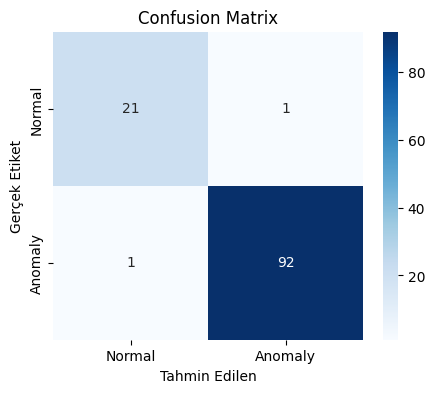

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_metrics(scores, labels, masks, anomaly_maps):
    """
    Gelişmiş Evaluation metrics hesapla:
    - Image-level AUROC
    - Optimal Threshold (F1 Score'a göre)
    - Accuracy, Precision, Recall, F1
    - Confusion Matrix
    """
    # 1. Image-level AUROC
    image_auroc = roc_auc_score(labels, scores)

    # 2. Optimal Threshold Bulma (En iyi F1 Score için)
    thresholds = np.linspace(min(scores), max(scores), 100)
    best_f1 = 0
    best_threshold = 0
    best_metrics = {
        'precision': 0, 'recall': 0, 'f1': 0, 'accuracy': 0
    }

    for th in thresholds:
        predicted_labels = (scores > th).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predicted_labels, average='binary', zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = th
            best_metrics = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy_score(labels, predicted_labels)
            }

    # 3. Sonuçları Ekrana Basma
    final_preds = (scores > best_threshold).astype(int)
    cm = confusion_matrix(labels, final_preds)

    print(f"\n--- Model Performans Raporu ---")
    print(f"Optimal Anomali Eşiği: {best_threshold:.4f}")
    print(f"AUROC Score: {image_auroc:.4f}")
    print(f"F1 Score   : {best_f1:.4f}")
    print(f"Accuracy   : {best_metrics['accuracy']:.4f}")
    print(f"Precision  : {best_metrics['precision']:.4f}")
    print(f"Recall     : {best_metrics['recall']:.4f}")
    print("-" * 30)

    # Confusion Matrix Çizimi
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title('Confusion Matrix')
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen')
    plt.show()

    # 4. Pixel-level AUROC (Eski mantık)
    pixel_scores = []
    pixel_labels = []
    for i, (label, mask, amap) in enumerate(zip(labels, masks, anomaly_maps)):
        if label == 1 and mask is not None:
            pixel_scores.extend(amap.flatten())
            pixel_labels.extend(mask.flatten())

    pixel_auroc = None
    if len(pixel_scores) > 0:
        pixel_auroc = roc_auc_score(pixel_labels, pixel_scores)

    # Dictionary döndür (Eski kodun bozulmaması için gerekli tüm anahtarları ekledim)
    return {
        'image_auroc': image_auroc,
        'pixel_auroc': pixel_auroc,
        'best_threshold': best_threshold,
        'f1_score': best_f1,
        'accuracy': best_metrics['accuracy'],
        'num_normal': np.sum(labels == 0),  # Hücre 10 için gerekli
        'num_anomaly': np.sum(labels == 1)  # Hücre 10 için gerekli
    }

# --- OTOMATİK ÇALIŞTIRMA KISMI ---
# Eğer 'scores' hafızada varsa (daha önce test yaptıysan) hemen çalıştırır:
if 'scores' in globals() and 'labels' in globals():
    print("✅ Değişkenler bulundu, analiz başlatılıyor...\n")
    metrics = calculate_metrics(scores, labels, masks, anomaly_maps)
else:
    print("⚠️ Fonksiyon tanımlandı ancak 'scores' değişkeni bulunamadı.")
    print("Lütfen önce modelin test/eğitim adımını (Hücre 9) tamamlayın.")


Generating visualizations...


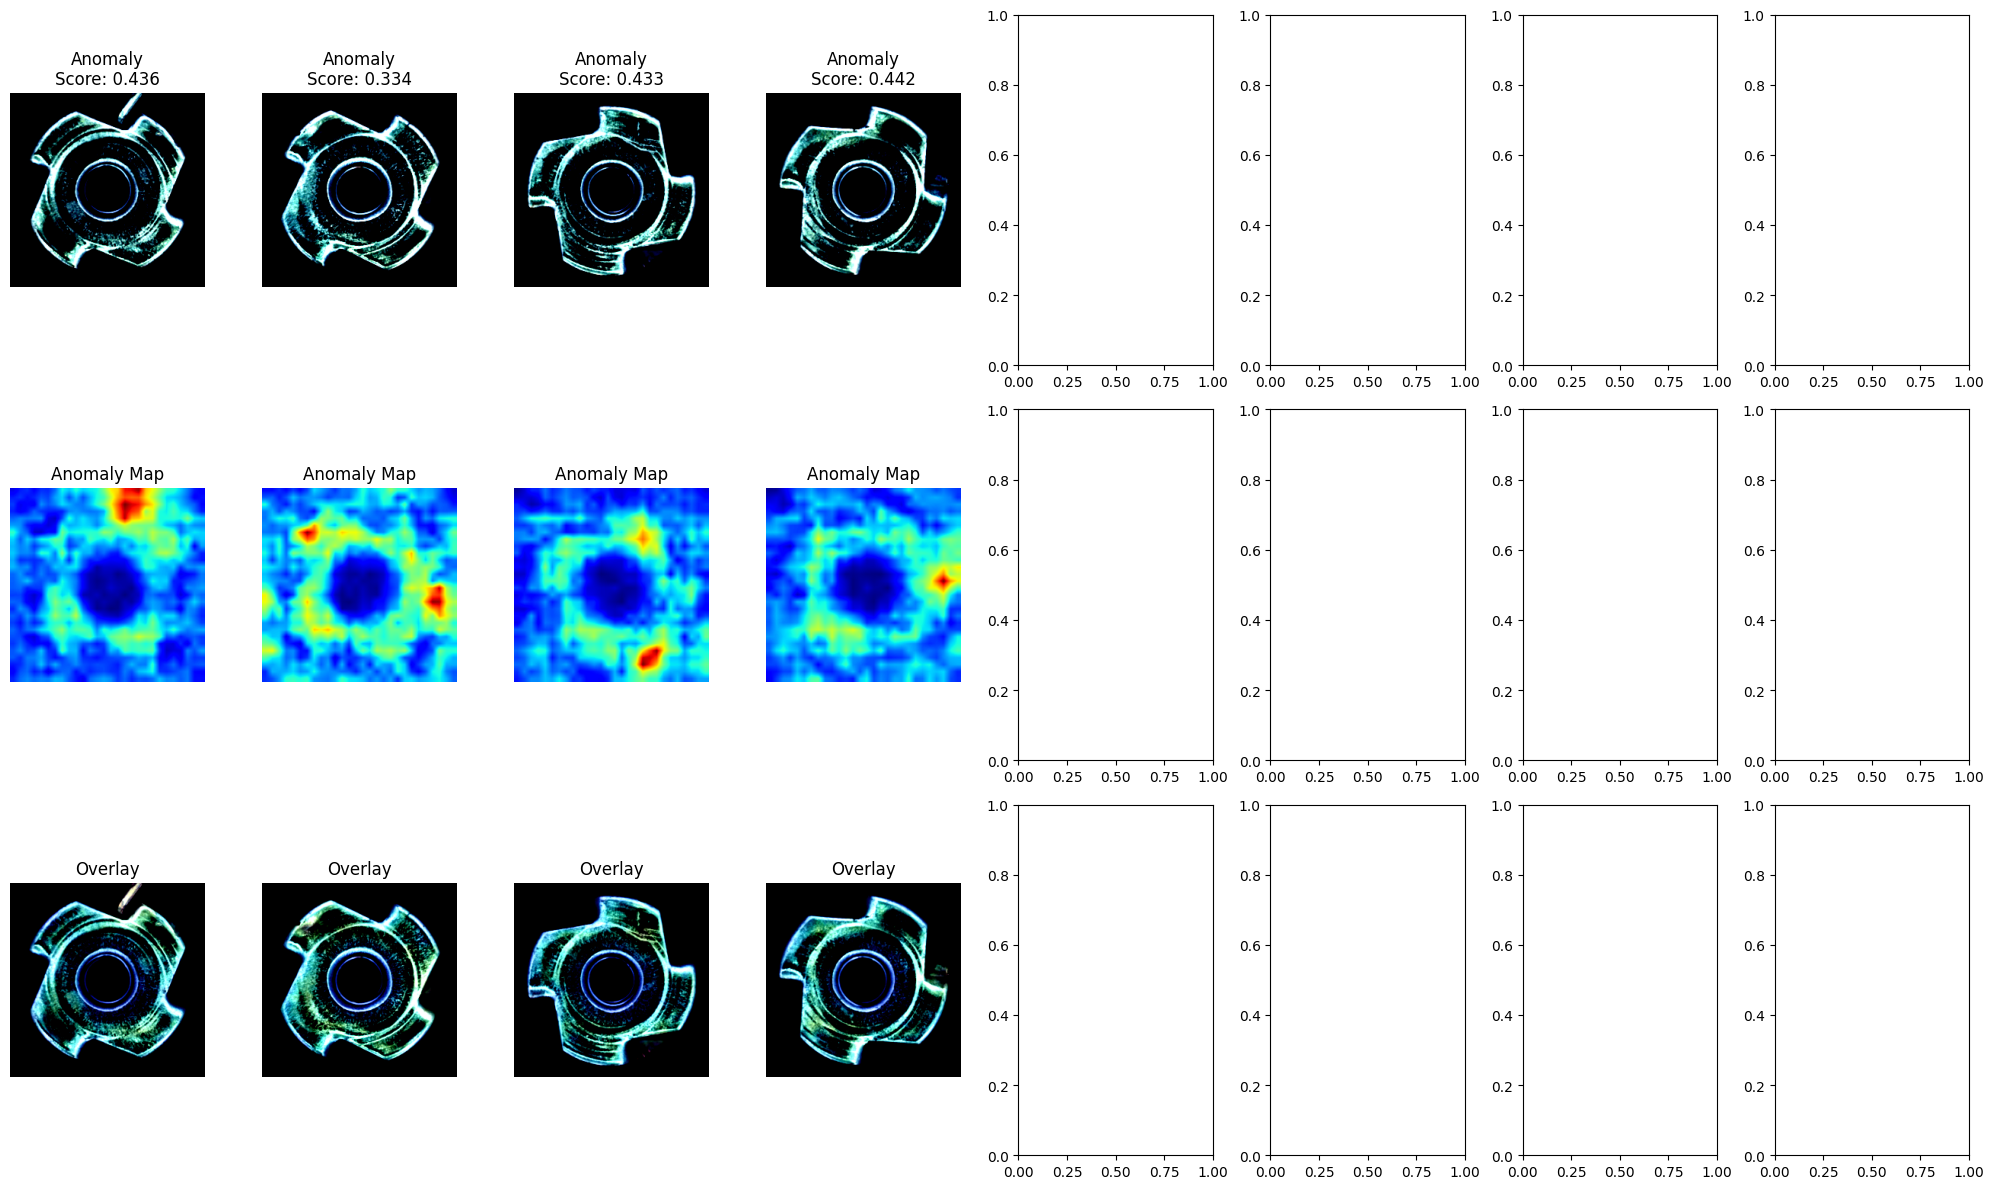

Visualization saved to Google Drive!
✅ Visualization completed!


In [ ]:

print("\nGenerating visualizations...")


test_images = []
for batch in test_loader:
    test_images.extend(batch['image'])
    if len(test_images) >= 16:
        break

visualize_results(
    test_images[:16],
    labels[:16],
    scores[:16],
    anomaly_maps[:16],
    save_path='/content/drive/MyDrive/patchcore_results.png'
)

print("Visualization saved to Google Drive!")
print("✅ Visualization completed!")

In [ ]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

def test_single_image(image_path, model, device, show_results=True):


    print(f"Testing image: {image_path}")


    try:
        if isinstance(image_path, str):

            image = Image.open(image_path).convert('RGB')
        else:

            image = image_path.convert('RGB')

        original_image = np.array(image)
        print(f"✅ Image loaded: {original_image.shape}")

    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None, None, None


    transform = transforms.Compose([
        transforms.Resize((model.input_size, model.input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])


    input_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, H, W]
    print(f"✅ Preprocessed: {input_tensor.shape}")


    with torch.no_grad():
        features = model.extract_features(input_tensor)
        b, c, h, w = features.shape


        features = features.reshape(b, c, h*w).permute(0, 2, 1)  # [1, HW, C]
        patch_features = features[0].cpu().numpy()  # [HW, C]

        print(f"✅ Features extracted: {patch_features.shape}")


    distances, _ = model.nn_model.kneighbors(patch_features)
    distances = distances.flatten()


    anomaly_map = distances.reshape(h, w)


    anomaly_map_resized = cv2.resize(anomaly_map, (model.input_size, model.input_size))

    anomaly_score = np.max(distances)


    if hasattr(model, 'threshold'):
        threshold = model.threshold
    else:

        normal_scores = scores[labels == 0]
        threshold = np.mean(normal_scores) + 2 * np.std(normal_scores)

    is_anomaly = anomaly_score > threshold
    confidence = abs(anomaly_score - threshold) / threshold

    print(f"🎯 Anomaly Score: {anomaly_score:.4f}")
    print(f"🎯 Threshold: {threshold:.4f}")
    print(f"🎯 Is Anomaly: {'YES' if is_anomaly else 'NO'}")
    print(f"🎯 Confidence: {confidence:.2f}")


    if show_results:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))


        axes[0, 0].imshow(original_image)
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')


        resized_for_display = cv2.resize(original_image, (model.input_size, model.input_size))
        axes[0, 1].imshow(resized_for_display)
        axes[0, 1].set_title(f'Resized ({model.input_size}x{model.input_size})')
        axes[0, 1].axis('off')


        im1 = axes[1, 0].imshow(anomaly_map_resized, cmap='jet')
        axes[1, 0].set_title(f'Anomaly Map\nScore: {anomaly_score:.4f}')
        axes[1, 0].axis('off')
        plt.colorbar(im1, ax=axes[1, 0])


        overlay = resized_for_display.copy()
        heatmap = cv2.applyColorMap(
            (anomaly_map_resized * 255 / anomaly_map_resized.max()).astype(np.uint8),
            cv2.COLORMAP_JET
        )
        overlay = cv2.addWeighted(overlay, 0.7, heatmap, 0.3, 0)

        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title(f'Overlay - {"ANOMALY" if is_anomaly else "NORMAL"}\nConfidence: {confidence:.2f}')
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.savefig('/content/sorunlusomun.jpeg', dpi=150, bbox_inches='tight')
        plt.show()

    return anomaly_score, is_anomaly, anomaly_map_resized


def test_uploaded_image():

    from google.colab import files

    print("📁 Upload your image file...")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"✅ File uploaded: {filename}")

        # Test et
        result = test_single_image(filename, model, device)
        return result
    else:
        print("❌ No file uploaded")
        return None

def test_drive_image(image_path):

    return test_single_image(image_path, model, device)


print("🧪 Single Image Test Cell Ready!")

if 'scores' in globals() and 'labels' in globals():
    normal_scores = scores[labels == 0]
    model.threshold = np.mean(normal_scores) + 2 * np.std(normal_scores)
    print(f"✅ Threshold set: {model.threshold:.4f}")
else:
    print("⚠️ Warning: No previous test results found. Using default threshold.")
    model.threshold = 0.5


🧪 Single Image Test Cell Ready!

Kullanım örnekleri:
1. Upload: test_uploaded_image()
2. Drive: test_drive_image('/content/drive/MyDrive/your_image.jpg')
3. Direct: test_single_image('path/to/image.jpg', model, device)
✅ Threshold set: 0.3163


📁 Upload your image file...


Saving 4.jpeg to 4.jpeg
✅ File uploaded: 4.jpeg
Testing image: 4.jpeg
✅ Image loaded: (700, 700, 3)
✅ Preprocessed: torch.Size([1, 3, 256, 256])
✅ Extracted features from layer2: torch.Size([1, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([1, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([1, 1536, 28, 28])
✅ Features extracted: (784, 1536)
🎯 Anomaly Score: 0.4627
🎯 Threshold: 0.3163
🎯 Is Anomaly: YES
🎯 Confidence: 0.46


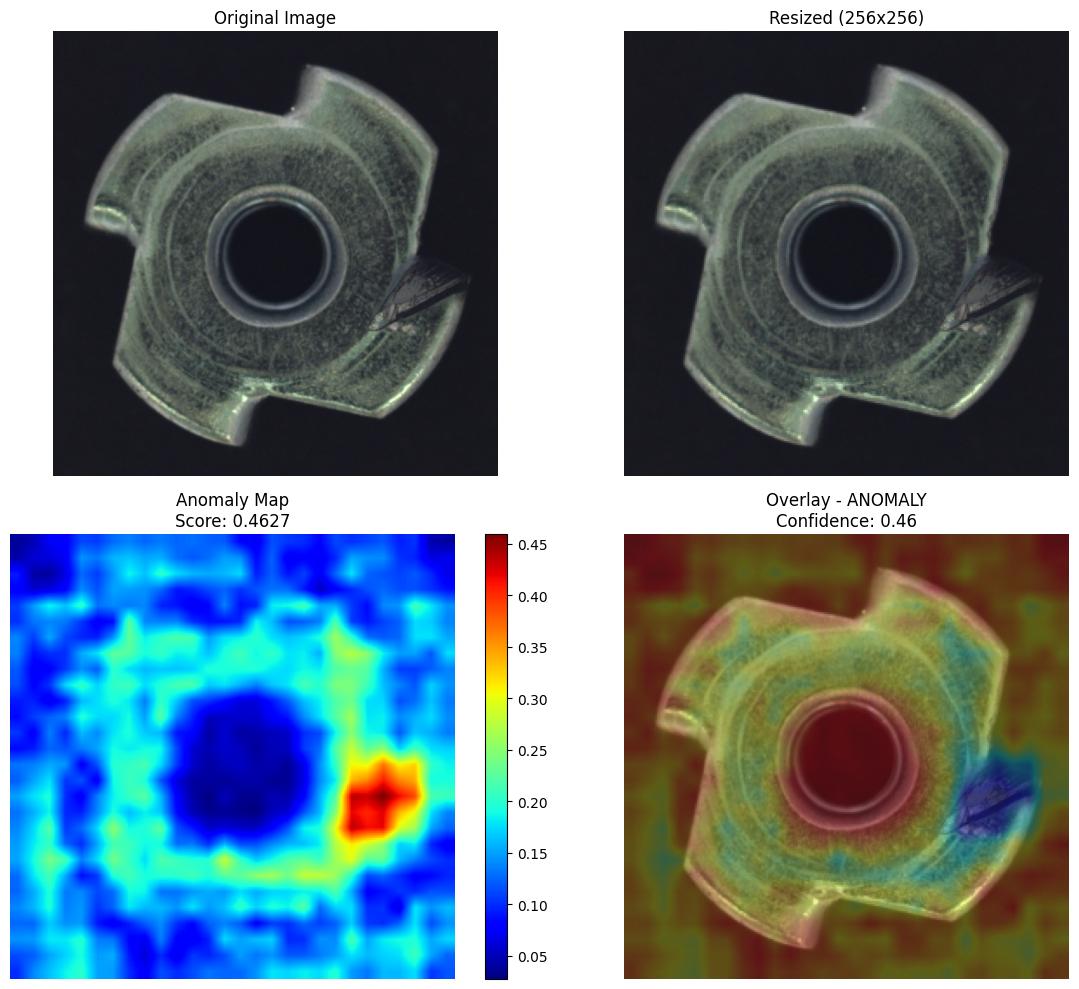

In [ ]:

result = test_uploaded_image()

📁 Upload your image file...


Saving 1.jpeg to 1.jpeg
✅ File uploaded: 1.jpeg
Testing image: 1.jpeg
✅ Image loaded: (700, 700, 3)
✅ Preprocessed: torch.Size([1, 3, 256, 256])
✅ Extracted features from layer2: torch.Size([1, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([1, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([1, 1536, 28, 28])
✅ Features extracted: (784, 1536)
🎯 Anomaly Score: 0.4722
🎯 Threshold: 0.3163
🎯 Is Anomaly: YES
🎯 Confidence: 0.49


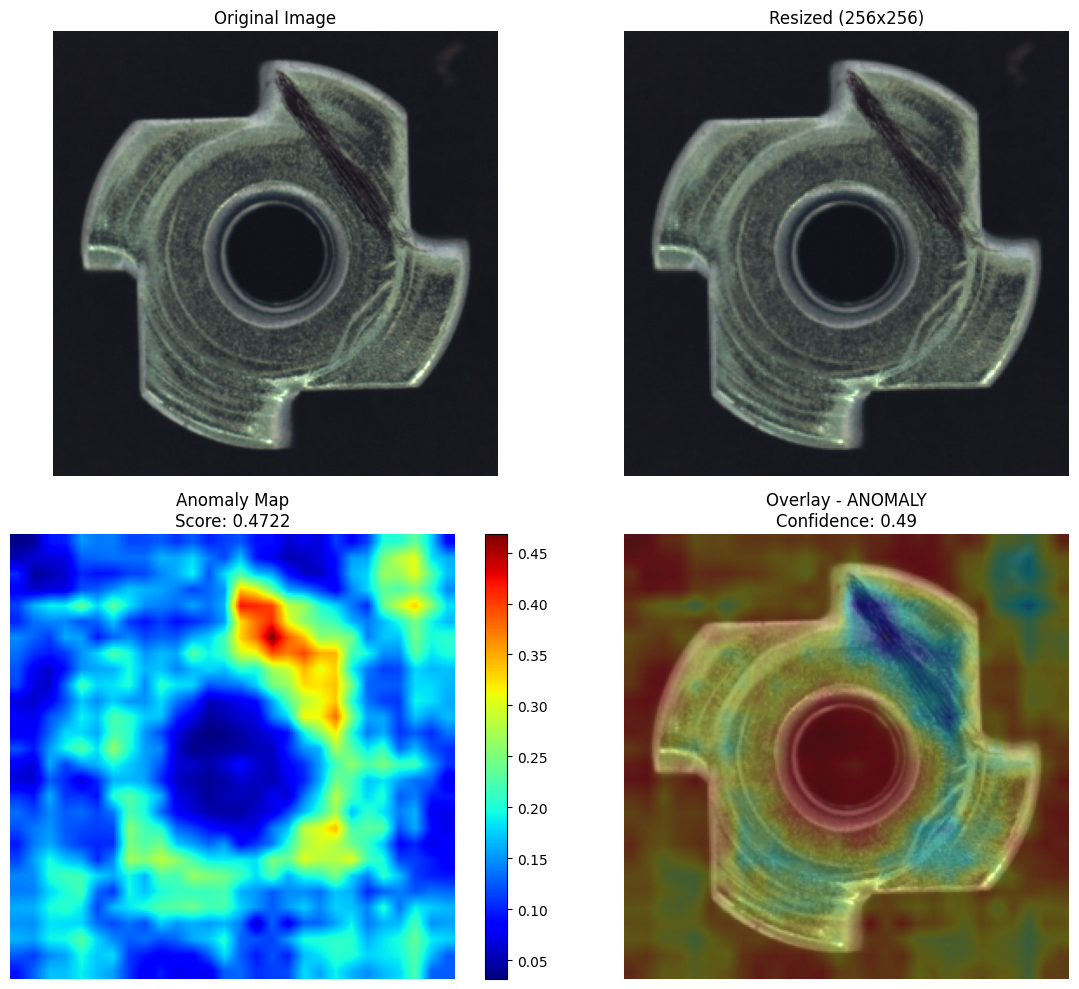

In [ ]:

result = test_uploaded_image()

📁 Upload your image file...


Saving 2.jpeg to 2.jpeg
✅ File uploaded: 2.jpeg
Testing image: 2.jpeg
✅ Image loaded: (700, 700, 3)
✅ Preprocessed: torch.Size([1, 3, 256, 256])
✅ Extracted features from layer2: torch.Size([1, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([1, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([1, 1536, 28, 28])
✅ Features extracted: (784, 1536)
🎯 Anomaly Score: 0.3956
🎯 Threshold: 0.3163
🎯 Is Anomaly: YES
🎯 Confidence: 0.25


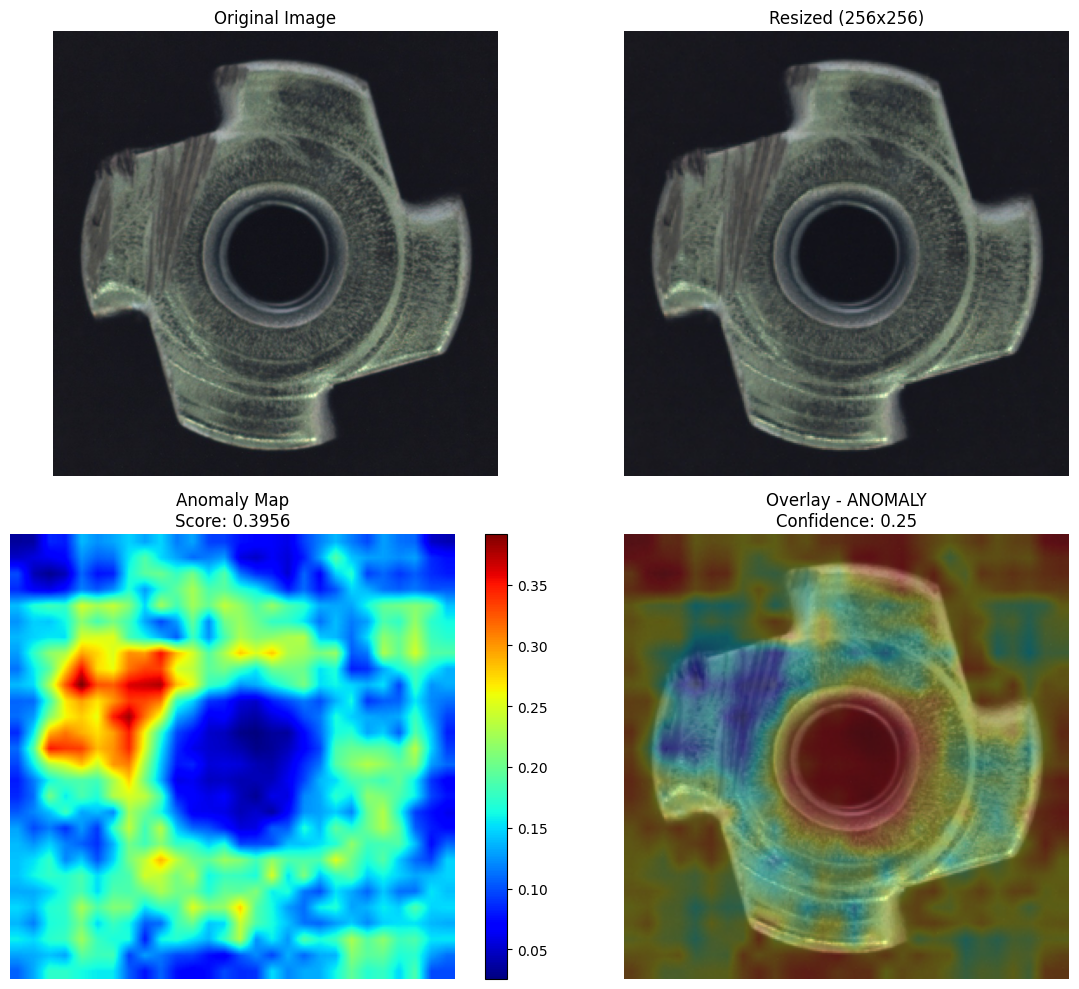

In [ ]:

result = test_uploaded_image()

📁 Upload your image file...


Saving 3.jpeg to 3.jpeg
✅ File uploaded: 3.jpeg
Testing image: 3.jpeg
✅ Image loaded: (700, 700, 3)
✅ Preprocessed: torch.Size([1, 3, 256, 256])
✅ Extracted features from layer2: torch.Size([1, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([1, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([1, 1536, 28, 28])
✅ Features extracted: (784, 1536)
🎯 Anomaly Score: 0.5130
🎯 Threshold: 0.3163
🎯 Is Anomaly: YES
🎯 Confidence: 0.62


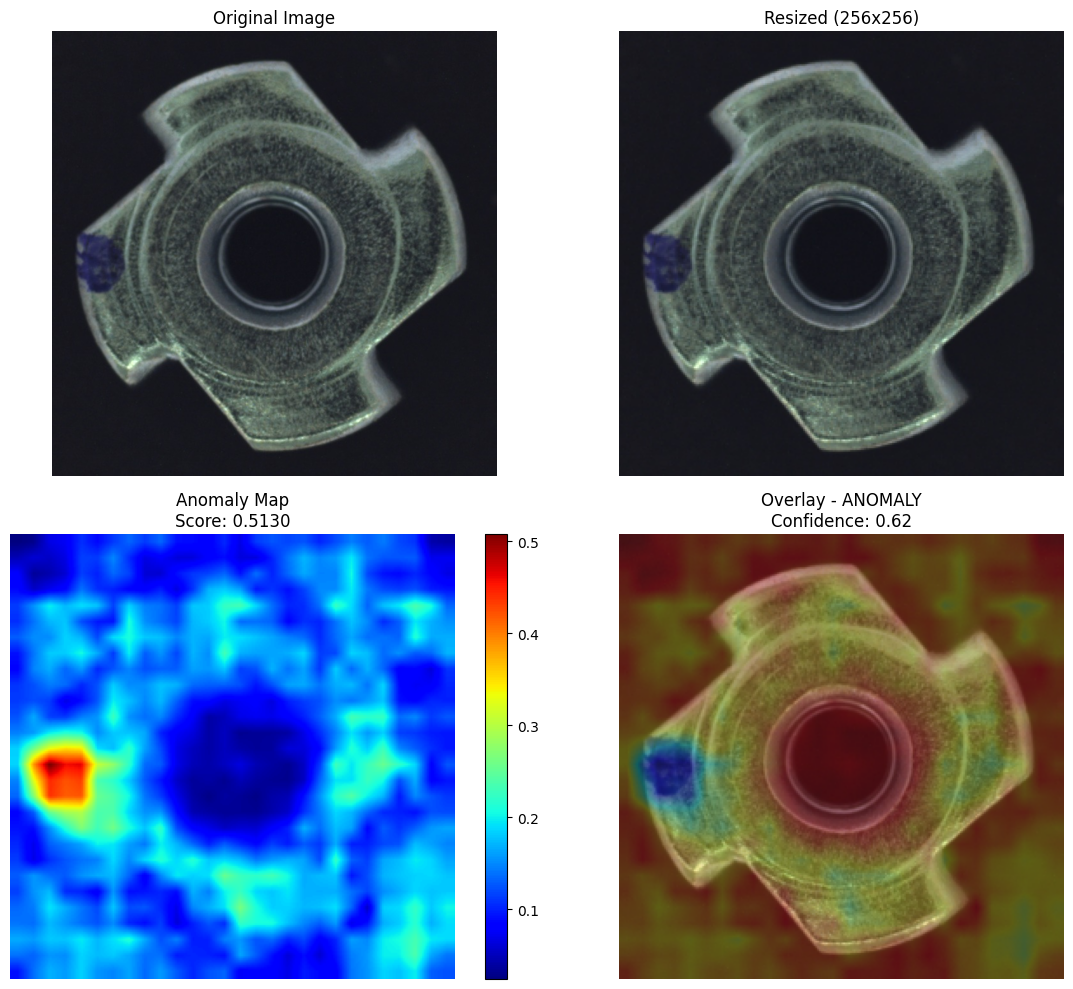

In [ ]:

result = test_uploaded_image()

📁 Upload your image file...


Saving temiz.jpeg to temiz.jpeg
✅ File uploaded: temiz.jpeg
Testing image: temiz.jpeg
✅ Image loaded: (700, 700, 3)
✅ Preprocessed: torch.Size([1, 3, 256, 256])
✅ Extracted features from layer2: torch.Size([1, 512, 28, 28])
✅ Extracted features from layer3: torch.Size([1, 1024, 28, 28])
✅ Concatenated features shape: torch.Size([1, 1536, 28, 28])
✅ Features extracted: (784, 1536)
🎯 Anomaly Score: 0.2812
🎯 Threshold: 0.3163
🎯 Is Anomaly: NO
🎯 Confidence: 0.11


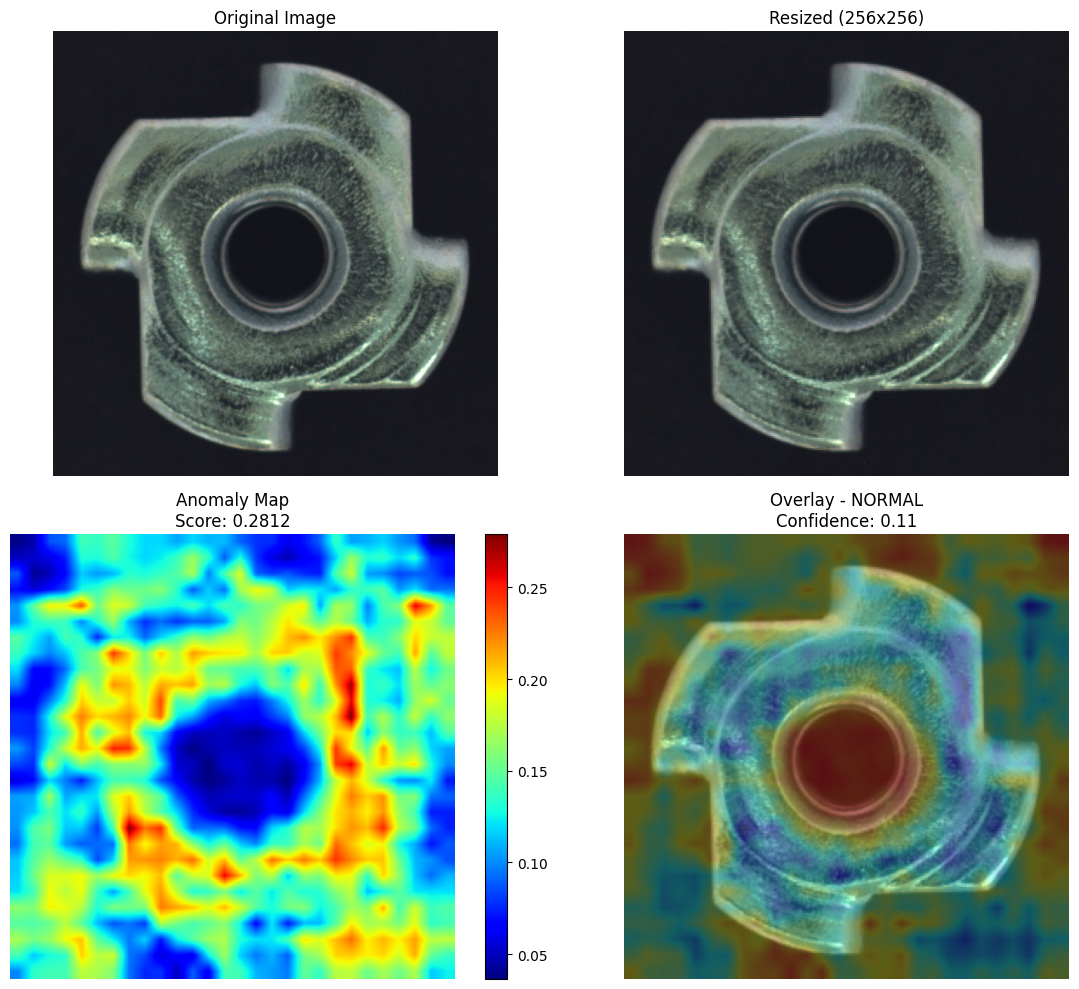

In [ ]:

result = test_uploaded_image()